In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
#!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA IMPORT

In [ ]:
import tensorflow as tf

In [ ]:

file="/content/drive/MyDrive/Sentiment Analysis/all-data.csv"

# Detect encoding
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.73, 'encoding': 'Windows-1252', 'language': ''}

In [ ]:
df=pd.read_csv(file,encoding='Windows-1252',header=None)

In [ ]:
df.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
mycolumns = ['Sentiment','Sentence']

df.columns=mycolumns

In [ ]:
pf=df[['Sentence','Sentiment']]

In [ ]:
pf.head()

,Sentence,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


# DATA PREPARATION

In [ ]:
 pf['Sentence']=pf["Sentence"].str.lower()

In [ ]:
pf['Sentiments'] = pf['Sentiment'].map({'neutral':0,'positive':1,'negative':-1})

# TF-IDF IMPLEMENTATION

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

analyze = vectorizer.build_analyzer()

In [ ]:
vectorizer.fit(pf["Sentence"])

features=vectorizer.transform(pf["Sentence"])

final=pd.DataFrame(features.todense(), columns = vectorizer.get_feature_names())

final['Sentiment']=pf['Sentiments']

In [ ]:
final.head()

,00,000,000063,002,0025,003,0030,007,008,01,0101138,012,0187274,019,02,023,027,029,03,030,031,035,04,045,046,047,0491,05,050,052,06,060,063,064,067,07,070,0711,0762,08,...,zao,zapadnye,zealand,zepro,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu,æhikauppa,æhivakuutus,æinen,æjoki,ækel,æki,æl,æliitto,ælt,æmeri,æn,ænekoski,ænen,ænge,ænnen,ænsi,ærnits,ærtsil,ærvi,ærvinen,æsein,æskyl,ætehuolto,ðl,ˆeur,Sentiment
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.147059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
final.describe()

,00,000,000063,002,0025,003,0030,007,008,01,0101138,012,0187274,019,02,023,027,029,03,030,031,035,04,045,046,047,0491,05,050,052,06,060,063,064,067,07,070,0711,0762,08,...,zao,zapadnye,zealand,zepro,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu,æhikauppa,æhivakuutus,æinen,æjoki,ækel,æki,æl,æliitto,ælt,æmeri,æn,ænekoski,ænen,ænge,ænnen,ænsi,ærnits,ærtsil,ærvi,ærvinen,æsein,æskyl,ætehuolto,ðl,ˆeur,Sentiment
count,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,...,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000
mean,0.001026,0.007455,0.000058,0.000074,0.000048,0.000050,0.000042,0.000095,0.000078,0.000613,0.000044,0.000206,0.000068,0.000095,0.000480,0.000060,0.000074,0.000056,0.000669,0.000049,0.000063,0.000045,0.000593,0.000183,0.000091,0.000070,0.000035,0.000462,0.000074,0.000063,0.000493,0.000108,0.000129,0.000055,0.000049,0.000467,0.000108,0.000055,0.000068,0.000427,...,0.000125,0.000055,0.000059,0.000059,0.000054,0.000062,0.000444,0.000113,0.000073,0.000045,0.000365,0.000048,0.000058,0.000043,0.000052,0.000048,0.000587,0.000060,0.000144,0.000173,0.000159,0.000043,0.000043,0.000057,0.000051,0.000209,0.000177,0.000150,0.000533,0.000067,0.000047,0.000238,0.000363,0.000104,0.000060,0.000057,0.000063,0.000095,0.000066,0.156624
std,0.015828,0.041798,0.004017,0.005170,0.003336,0.003453,0.002890,0.006592,0.005395,0.013120,0.003066,0.008330,0.004765,0.006592,0.012415,0.004165,0.005180,0.003917,0.015162,0.003381,0.004366,0.003109,0.014049,0.007521,0.006302,0.004873,0.002433,0.012788,0.005180,0.004366,0.012550,0.007486,0.006351,0.003820,0.003435,0.013567,0.007551,0.003843,0.004721,0.010775,...,0.006348,0.003851,0.004080,0.004080,0.003732,0.004339,0.012356,0.007879,0.005067,0.003123,0.009707,0.003347,0.004017,0.002967,0.003630,0.003372,0.012971,0.004152,0.007088,0.006955,0.008007,0.003021,0.002967,0.003977,0.003524,0.008411,0.007121,0.007413,0.012736,0.004681,0.003244,0.008483,0.010453,0.007254,0.004152,0.003980,0.004407,0.006622,0.004569,0.617616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
final.Sentiment.sum()

759

#  Data Cleaning

In [ ]:
final = final.drop(final.columns[final.sum() < 0.5], axis=1)
#final['Sentiment'] = Doc[0]



In [ ]:
final.shape

(4846, 4815)

# TEST - TRAIN SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X = final.drop('Sentiment',axis=1)
y = final['Sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# RANDOM FOREST IMPLEMENTATION AND TUNING

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score,mean_absolute_error,mean_squared_error


In [ ]:
test_error = []

for n in range(1,10):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='auto')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
    print(accuracy_score(test_preds,y_test)*100)

62.2680412371134
61.03092783505155
64.74226804123711
67.42268041237114
68.24742268041237
69.89690721649484
70.10309278350515
69.0721649484536
68.45360824742268


In [ ]:
test_error = []

for n in range(1,20):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='sqrt')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
    print(accuracy_score(test_preds,y_test)*100)

60.41237113402062
60.824742268041234
63.092783505154635
66.59793814432989
65.56701030927834
70.51546391752578
70.30927835051546
69.27835051546391
70.72164948453609
69.69072164948453
67.42268041237114
70.51546391752578
72.98969072164948
69.0721649484536
71.75257731958763
71.75257731958763
69.0721649484536
71.54639175257732
70.9278350515464


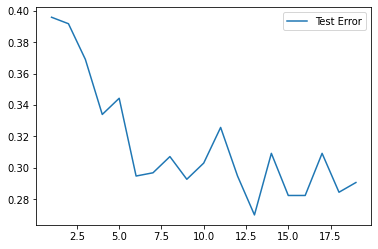

In [ ]:
plt.plot(range(1,20),test_error,label='Test Error')
plt.legend()

In [ ]:
model = RandomForestClassifier(n_estimators=9,max_features='auto',random_state=101)

model.fit(X_train,y_train)

pred_RF = model.predict(X_test)

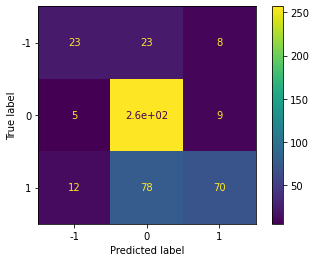

In [ ]:
plot_confusion_matrix(model,X_test,y_test)

#### MODEL TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV        # takes much time to run on pc

n_estimators=[64,100,128,200]
max_features= ['auto','sqrt']


param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             }  

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)

grid.fit(X_train,y_train)

grid.best_params_

KeyboardInterrupt: ignored

# XGB IMPLEMENTATION

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.58%


# NEURAL NETWORK IMPLEMENTATION

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train_scaled = scaler.transform(X_train)

X_test_scaled  = scaler.transform(X_test)

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = 'adam',loss='mse')

model.fit(X_train_scaled,y_train,epochs=50,batch_size=256)

Epoch 1/50
18/18 [==============================] - 1s 13ms/step - loss: 0.3956
Epoch 2/50
18/18 [==============================] - 0s 13ms/step - loss: 0.3780
Epoch 3/50
18/18 [==============================] - 0s 13ms/step - loss: 0.3548
Epoch 4/50
18/18 [==============================] - 0s 13ms/step - loss: 0.3153
Epoch 5/50
18/18 [==============================] - 0s 13ms/step - loss: 0.2687
Epoch 6/50
18/18 [==============================] - 0s 13ms/step - loss: 0.2178
Epoch 7/50
18/18 [==============================] - 0s 14ms/step - loss: 0.1691
Epoch 8/50
18/18 [==============================] - 0s 13ms/step - loss: 0.1241
Epoch 9/50
18/18 [==============================] - 0s 14ms/step - loss: 0.0879
Epoch 10/50
18/18 [==============================] - 0s 13ms/step - loss: 0.0618
Epoch 11/50
18/18 [==============================] - 0s 13ms/step - loss: 0.0464
Epoch 12/50
18/18 [==============================] - 0s 13ms/step - loss: 0.0373
Epoch 13/50
18/18 [==================

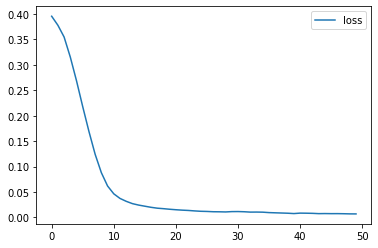

In [ ]:
loss= pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
#model.evaluate(X_test_scaled,y_test,verbose=0)

pred_nn =model.predict(X_test_scaled)

#checking for errors



In [ ]:
mean_squared_error(y_test,pred_nn)

0.3709480906695036

## NEURAL NETWORKS AFTER  LABEL ENCODING

In [ ]:
## This is made seperate as we have used label encoding which is different than previous 3 models
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
X.shape

(4846, 10071)

In [ ]:
all_labels = pf['Sentiment'].values

In [ ]:
all_inputs = X.values

In [ ]:
#all_labels

In [ ]:
all_inputs

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.147059, 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [ ]:
encoder = LabelEncoder()
encoder.fit(all_labels)
encoded_Y = encoder.transform(all_labels)

dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=all_inputs.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
all_inputs.shape

(4846, 10071)

In [ ]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(all_inputs,dummy_y, test_size=0.1, random_state=101)

In [ ]:
train_x = np.asarray(X_train_encoded)
train_y = np.asarray(y_train_encoded)
validation_x = np.asarray(X_test_encoded)
validation_y = np.asarray(y_test_encoded)

In [ ]:
model.fit(train_x,train_y, epochs=30)

Epoch 1/30
137/137 [==============================] - 1s 5ms/step - loss: 0.9241 - accuracy: 0.6054
Epoch 2/30
137/137 [==============================] - 1s 5ms/step - loss: 0.5632 - accuracy: 0.7778
Epoch 3/30
137/137 [==============================] - 1s 5ms/step - loss: 0.2353 - accuracy: 0.9312
Epoch 4/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0963 - accuracy: 0.9757
Epoch 5/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0462 - accuracy: 0.9901
Epoch 6/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0277 - accuracy: 0.9938
Epoch 7/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0206 - accuracy: 0.9952
Epoch 8/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0150 - accuracy: 0.9966
Epoch 9/30
137/137 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9959
Epoch 10/30
137/137 [==============================] - 1s 6ms/step - loss: 0.0119 - accuracy: 0.9968

In [ ]:
pred_train = model.predict(train_x)
scores = model.evaluate(train_x, train_y, verbose=0)
print('Accuracy on training data: {} \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(validation_x)
scores2 = model.evaluate(validation_x, validation_y, verbose=0)
print('Accuracy on test data: {} \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))   

Accuracy on training data: 0.9988534450531006 
 Error on training data: 0.001146554946899414
Accuracy on test data: 0.7381443381309509 
 Error on test data: 0.2618556618690491


In [ ]:
pred_test

array([[8.8842016e-06, 9.9998951e-01, 1.5676657e-06],
       [1.3803192e-08, 6.7632946e-08, 9.9999988e-01],
       [2.6943630e-03, 1.3400322e-03, 9.9596560e-01],
       ...,
       [1.1578082e-04, 6.8954879e-01, 3.1033537e-01],
       [1.3865074e-05, 9.3717033e-01, 6.2815756e-02],
       [9.9085414e-01, 7.3282588e-03, 1.8175717e-03]], dtype=float32)

# Decision Trees


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth = 15).fit(X_train,y_train)
y_pred = dtree.predict(X_test)



In [ ]:
print(y_pred)

[ 0  0  0  0  0  0  0  0 -1  0  1 -1  0  0  0  0  0  0  0  1  1  0 -1  0
  0  0  1 -1  0  0  0  0  1  1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  1  1  0
 -1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  0  1  1  0  0  0  1  0  1  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  1  1  0 -1  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  1  1
  0  0  1  1  0  1 -1  0 -1  0  0  0  0  0  0  1  1 -1 -1  0  0  0  0  0
  0  1  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  0  0  1  1  0  0  0
  1  0  1  0  0  0  0  0  1  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0
  0 -1 -1  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  1  0
  0  1  0  0  0  0  0  0  1  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  1
  0  0 -1  0  0  0  0  0  1  0  0  0  0  0 -1  0  1  0  0  1  0  1  0  0
  0  0  1  0  0  0  0  0  0  0  1  0 -1  0  1  0  0  0  0  0  0  1  0  0
  0  0  0  0  1  0  1  1  0  0  0  0  0  0  0  0  0

In [ ]:
count = 0
#for i in range(len(y_pred)):
 # if y_pred[i]==y_test[i]:
  #  count = count+1

        



  
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))      
#accuracy = count/len(y_pred)
#print('accuracy = ' ,accuracy*100 , '%')

Accuracy: 68.04%


# UNIDIRECTIONAL LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(tf.keras.layers.LSTM(64,return_sequences=True, input_shape=(1,train_x.shape[1])))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(all_inputs,dummy_y, test_size=0.1, random_state=101)

In [ ]:
train_x = np.asarray(X_train_encoded)
train_y = np.asarray(y_train_encoded)
validation_x = np.asarray(X_test_encoded)
validation_y = np.asarray(y_test_encoded)
#X_train_dim = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))


In [ ]:
X_train_lstm = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))

In [ ]:
y_train_lstm = np.reshape(train_y, (train_y.shape[0], 1, train_y.shape[1]))

In [ ]:
X_train_lstm.shape

(4361, 1, 4814)

In [ ]:
train_y.shape

(4361, 3)

In [ ]:
model_lstm.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 64)             1249024   
_________________________________________________________________
dense_13 (Dense)             (None, 1, 3)              195       
Total params: 1,249,219
Trainable params: 1,249,219
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.fit(X_train_lstm,y_train_lstm, epochs=30)

Epoch 1/30
137/137 [==============================] - 3s 19ms/step - loss: 0.1976 - accuracy: 0.9482
Epoch 2/30
137/137 [==============================] - 3s 19ms/step - loss: 0.1232 - accuracy: 0.9768
Epoch 3/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0813 - accuracy: 0.9846
Epoch 4/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0561 - accuracy: 0.9899
Epoch 5/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0410 - accuracy: 0.9924
Epoch 6/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0317 - accuracy: 0.9940
Epoch 7/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0250 - accuracy: 0.9952
Epoch 8/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0213 - accuracy: 0.9956
Epoch 9/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0173 - accuracy: 0.9959
Epoch 10/30
137/137 [==============================] - 3s 19ms/step - loss: 0.0149 - accura

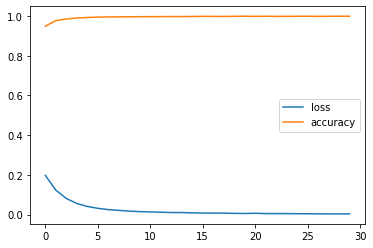

In [ ]:
model_lstm_loss = pd.DataFrame(model_lstm.history.history)
model_lstm_loss.plot()

In [ ]:
X_test_lstm = np.reshape(validation_x, (validation_x.shape[0], 1, validation_x.shape[1]))

In [ ]:
y_test_lstm = np.reshape(validation_y, (validation_y.shape[0], 1, validation_y.shape[1]))

In [ ]:
pred_train_lstm = model_lstm.predict(X_train_lstm)
scores = model_lstm.evaluate(X_train_lstm, y_train_lstm, verbose=0)

print('Accuracy on training data: {} \n Error on training data: {}'.format(scores[1]*100, (1 - scores[1])*100))   
 
pred_test_lstm= model_lstm.predict(X_test_lstm)
scores2 = model_lstm.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print('Accuracy on test data: {} \n Error on test data: {}'.format(scores2[1]*100, (1 - scores2[1])*100))   

Accuracy on training data: 99.90828037261963 
 Error on training data: 0.0917196273803711
Accuracy on test data: 74.02061820030212 
 Error on test data: 25.979381799697876


In [ ]:
pred_test_lstm.shape

(485, 1, 3)

In [ ]:
pred_lstm_a=np.reshape(pred_test_lstm, (pred_test_lstm.shape[0], pred_test_lstm.shape[2]))

In [ ]:
final_predict_lstm=np.rint(pred_lstm_a)


In [ ]:
ok

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
final_predict_lstm

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
accuracy = accuracy_score(validation_y,final_predict_lstm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))  

Accuracy: 73.40%


# BI DIRECTIONAL LSTM


In [ ]:
model_lstm_2 = Sequential()
model_lstm_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True, input_shape=(1,train_x.shape[1]))))
model_lstm_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)))
model_lstm_2.add(Dense(3, activation='softmax'))
model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model_lstm_2.fit(X_train_lstm,y_train_lstm, epochs=30)

Epoch 1/30
137/137 [==============================] - 8s 36ms/step - loss: 0.8985 - accuracy: 0.6129
Epoch 2/30
137/137 [==============================] - 5s 36ms/step - loss: 0.5769 - accuracy: 0.7310
Epoch 3/30
137/137 [==============================] - 5s 36ms/step - loss: 0.3015 - accuracy: 0.8801
Epoch 4/30
137/137 [==============================] - 5s 36ms/step - loss: 0.1267 - accuracy: 0.9658
Epoch 5/30
137/137 [==============================] - 5s 36ms/step - loss: 0.0548 - accuracy: 0.9862
Epoch 6/30
137/137 [==============================] - 5s 36ms/step - loss: 0.0300 - accuracy: 0.9924
Epoch 7/30
137/137 [==============================] - 5s 36ms/step - loss: 0.0217 - accuracy: 0.9950
Epoch 8/30
137/137 [==============================] - 5s 36ms/step - loss: 0.0158 - accuracy: 0.9959
Epoch 9/30
137/137 [==============================] - 5s 36ms/step - loss: 0.0132 - accuracy: 0.9963
Epoch 10/30
137/137 [==============================] - 5s 36ms/step - loss: 0.0107 - accura

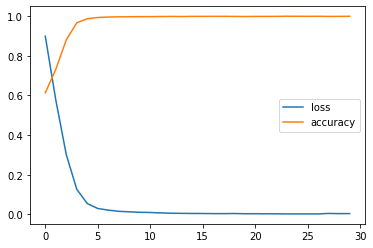

In [ ]:
model_loss_lstm_2 = pd.DataFrame(model_lstm_2.history.history)
model_loss_lstm_2.plot()

In [ ]:
pred_test_lstm_2=model_lstm_2.predict(X_test_lstm)

In [ ]:
pred_test_lstm_2=np.reshape(pred_test_lstm_2, (pred_test_lstm_2.shape[0], pred_test_lstm_2.shape[2]))

In [ ]:
final_predict_lstm_2=np.rint(pred_test_lstm_2)

In [ ]:
accuracy = accuracy_score(validation_y,final_predict_lstm_2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))  

Accuracy: 72.37%
